# Baseline GAN model for assessment

**Module:** Deep Neural Networks and Learning Systems

In this demonstration and notebook, we will develop a baseline model for your assessment task.


---


**Objectives:**

- Develop the baseline convolutional GAN
- Understand the potential modifications to this model to be performed as an assessment

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import imageio
import os
import torchvision.utils as vutils
import torch.nn as nn
import torchvision.utils as vutils

## Setting up the dataset

The dataset is located in a different drive (public). Therefore, we need to add a shortcut to the data directory in our own drive.

**Original dataset**

Open the dataset external drive: [https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb](https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb) and click in add shortcut.

**Reduced images**

I have also created a separate folder with reduced size images to accelerate model training. *You also need a shortcut to this folder in your own drive*:

https://drive.google.com/drive/folders/18niX9leMkIxIhD1st-f6yR0s1HWTGBkV?usp=drive_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
root_dir = '/content/drive/MyDrive/birth certificate/Untitled form (File responses)'

algonauts_dir = 'algonauts_2023_tutorial_data'
reduced_images_dir = 'reduced_images_algonauts'

# Loading reduced images
reduced_images = np.load( os.path.join(root_dir, reduced_images_dir, 'subj01', 'images.npy') )

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Utility functions

The following functions can be used to load the FMRI data from a given subject, load activity from a given region of interest or loading the corresponding image.

In [ ]:
# @title Helper functions
# Loads all the fmri data associated to a given subject
def load_fmri_of_subject( subj, hemisphere, directory = root_dir ):
  subj = subj # Subject
  hemisphere = hemisphere # Which side of the brain
  # Listing directory
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
  return brain_activity

# Loads the data associated to a specific part of the brain (Some will be empty, it varies by subject)
def load_fmri_region_of_interest( subj, roi, hemisphere, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
    # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'

  # Loading the roi masks (To locate the activations of a given region)
  roi_class_dir = os.path.join(data_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
  roi_map_dir = os.path.join(data_dir, 'roi_masks',
      'mapping_'+roi_class+'.npy')
  roi_class_idx = np.load(roi_class_dir)
  roi_map = np.load(roi_map_dir, allow_pickle=True).item()
  roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
  challenge_roi = np.asarray(roi_class_idx == roi_mapping, dtype=int)

  # Selection the appropriate data
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

  fmri_roi_data = brain_activity[:,np.where(challenge_roi)[0]]

  return fmri_roi_data

# Load a particular image from a subject
def load_image_subject( subj, img, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
  test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
  train_img_list = os.listdir(train_img_dir)
  train_img_list.sort()
  test_img_list = os.listdir(test_img_dir)
  test_img_list.sort()

  img_dir = os.path.join(train_img_dir, train_img_list[img])
  train_img = Image.open(img_dir).convert('RGB') # Image library (PIL)
  return train_img

def load_reduced_image_subject( subj, img, directory = root_dir ):
  image = reduced_images[img]

  return Image.fromarray(image)

def showImage( ax, image, title = '' ):
  ''' This is a helper function that allows you to show the results of your training '''
  image = (image - torch.min(image))/(torch.max(image)-torch.min(image)) # image 0...1
  ax.imshow(image.permute(1,2,0)) # You need reorganize the dimension (3, H,  W) -> (H, W, 3)
  ax.set_title(title)


## Building a dataset.

First we create a dataset that represents ALL the brain activity. If you want to use a particular region you need to modify this class

In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# This dataset provides batches of image, brain activity, pairs
class BrainDataSet(Dataset):
  def __init__( self, subject, hemisphere, transform = None ):
    self.subject = subject # We need to select a particular object
    self.hemisphere = hemisphere
    self.fmri_data = load_fmri_of_subject( subject, hemisphere ) # Load all the data from the subjects
    self.data_len, self.num_samples = self.fmri_data.shape # Get the shape MxN
    self.transform = transform

  def __len__(self):
    return self.data_len # len is the total number of images

  def __getitem__( self, idx ):
    # Get FMRI data
    x = self.fmri_data[idx, :]
    # Obtain images
    img = load_reduced_image_subject( subj = self.subject, img = idx ) # This is slow. If you can you should preload all images
    return self.transform(img) if self.transform else img, torch.from_numpy(x),


subject = 1 # change this to change the subject
hemisphere = 1 # change this to change the hemisphere (1 left, 2 right)
# You define to define a transform:
# 1. Convert the images to Tensors
# 2. Resize (32, 32)
# 3. Normalize
resize_normalize = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.Resize((32,32)), # We downsample the images a lot. Bigger images take more time to train
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

# Create the dataset
myDataset = BrainDataSet( subject, hemisphere, resize_normalize)

Creating our train loader

In [ ]:
# Creating a data loader
# Shuffles
# Organizes in batches
train_loader = DataLoader( dataset = myDataset,
                          #  num_workers = 2, # Parallel to make it faster
                          #  prefetch_factor=16, # This is used to preload some of the data
                           batch_size = 32,
                           shuffle = True )

torch.Size([32, 3, 32, 32])


Text(0.5, 1.0, 'Brain activity')

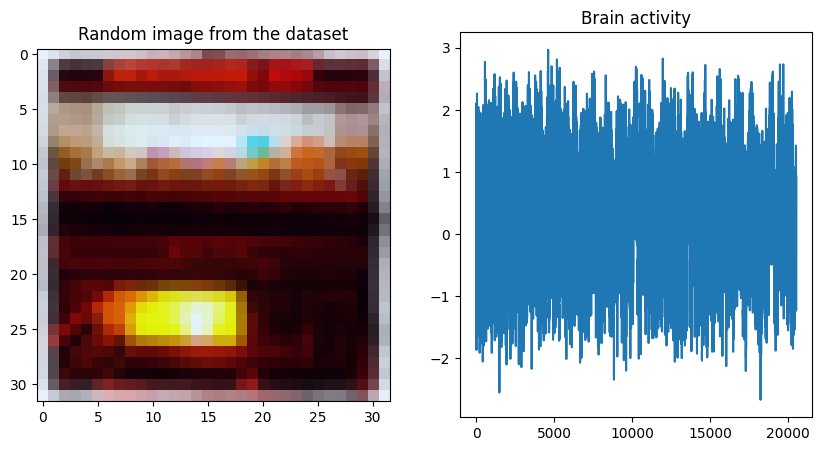

In [ ]:
img, fmri = next(iter(train_loader))

print(img.shape)
fig, ax = plt.subplots(1,2, figsize = (10, 5))

showImage( ax[0], img[0], 'Random image from the dataset')
ax[1].plot(fmri[0])
ax[1].set_title('Brain activity')

##**Training the generative model**

We start by building our generative model

In [ ]:
# Your DCGAN (Deep Convolutional GAN) model here

import torch.optim as optim

# Hyperparameters
batch_size = 64
lr = 0.0002
num_epochs = 10
nz = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1, device=device).type(torch.float)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_D: {errD_real+errD_fake:.4f} Loss_G: {errG:.4f}')




[0/10][0/308] Loss_D: 1.3876 Loss_G: 1.7000
[0/10][100/308] Loss_D: 0.0905 Loss_G: 6.8058
[0/10][200/308] Loss_D: 0.2118 Loss_G: 4.4783
[0/10][300/308] Loss_D: 0.5375 Loss_G: 4.9411
[1/10][0/308] Loss_D: 0.2861 Loss_G: 4.1618
[1/10][100/308] Loss_D: 0.2711 Loss_G: 3.4555
[1/10][200/308] Loss_D: 0.5480 Loss_G: 2.9469
[1/10][300/308] Loss_D: 0.3701 Loss_G: 5.0520
[2/10][0/308] Loss_D: 0.1996 Loss_G: 3.8527
[2/10][100/308] Loss_D: 0.2520 Loss_G: 3.6157
[2/10][200/308] Loss_D: 0.3327 Loss_G: 3.8336
[2/10][300/308] Loss_D: 0.3917 Loss_G: 3.1193
[3/10][0/308] Loss_D: 0.5926 Loss_G: 2.3367
[3/10][100/308] Loss_D: 0.4990 Loss_G: 2.6549
[3/10][200/308] Loss_D: 0.4377 Loss_G: 2.4382
[3/10][300/308] Loss_D: 0.4461 Loss_G: 2.9535
[4/10][0/308] Loss_D: 0.3737 Loss_G: 3.0592
[4/10][100/308] Loss_D: 0.2196 Loss_G: 3.9501
[4/10][200/308] Loss_D: 0.3413 Loss_G: 3.0857
[4/10][300/308] Loss_D: 0.9591 Loss_G: 2.5182
[5/10][0/308] Loss_D: 0.4752 Loss_G: 2.8581
[5/10][100/308] Loss_D: 0.5750 Loss_G: 3.9453


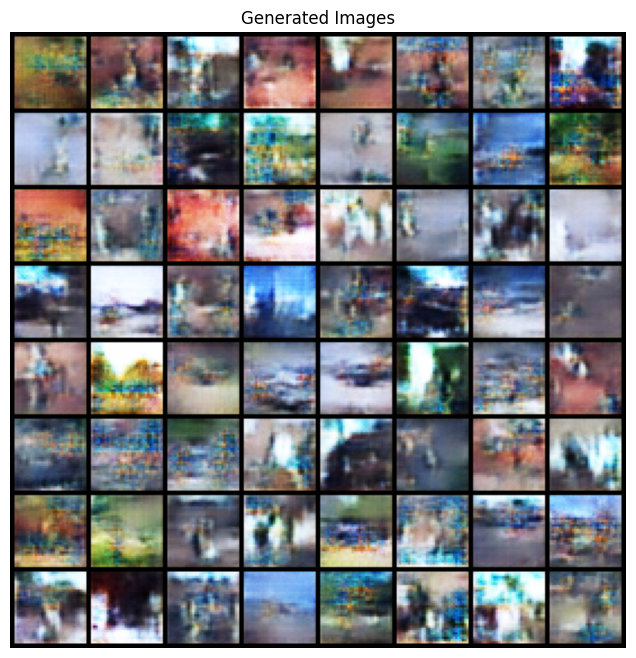

In [ ]:
# Generate and visualize images
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(vutils.make_grid(fake, padding=2, normalize=True).permute(1,2,0))
plt.show()

## **Creating a decoder from the brain activity**

Now we create a personalized neural network that translates brain signals into latent vectors or include the brain signal as a condition for your GAN above. Or come up with a different way of including the brain signal in your training.

In [ ]:
# Create and train you brain decoder

Train your decoder

In [ ]:
# Training code here

##**Reconstructing images from brain activity.**

Now that we have trained our brain decoder, we can try to reconstruct the image from brain activity.

In [ ]:
# Your code here


#**Example questions you can ask:**

1. (Changes of the model at least 1) Does adding more layer to BrainDecoder improve the result? The quality? Or adding Convolutional layers? Or trying different loss function? Doing PCA before?
2. Is the reconstruction better if we use brain activtity from region V1d (which is purely visual) or EBA which is related to places (X vs Y, two different regions)
3. Compare different subject? Subj 1 vs Subj 2
4. Choose categories of images (Cities vs Nature)
5. Can try to generate a text description of the image (advanced)
6. Classification: generate some labels from the images (using ResNet), you use you latent code to train a classifier
7. Sentiment

In [ ]:
# Initialize models
nz = 100  # latent vector size
ngf = 64  # generator feature map size
ndf = 64  # discriminator feature map size
nc = 3  # number of channels (e.g., RGB)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models without arguments
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 20

# Lists to store losses
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD_real.item() + errD_fake.item())

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_D: {errD_real.item() + errD_fake.item():.4f} Loss_G: {errG.item():.4f}')

[0/5][0/308] Loss_D: 1.4202 Loss_G: 1.6276
[0/5][50/308] Loss_D: 0.2163 Loss_G: 8.3020
[0/5][100/308] Loss_D: 0.0330 Loss_G: 6.9889
[0/5][150/308] Loss_D: 0.1085 Loss_G: 4.1460
[0/5][200/308] Loss_D: 0.1751 Loss_G: 4.9846
[0/5][250/308] Loss_D: 0.4396 Loss_G: 6.6969
[0/5][300/308] Loss_D: 0.2966 Loss_G: 4.1882
[1/5][0/308] Loss_D: 0.8413 Loss_G: 3.8621
[1/5][50/308] Loss_D: 0.1921 Loss_G: 4.1620
[1/5][100/308] Loss_D: 0.3823 Loss_G: 3.5715
[1/5][150/308] Loss_D: 0.7670 Loss_G: 3.4181
[1/5][200/308] Loss_D: 0.5218 Loss_G: 2.4210
[1/5][250/308] Loss_D: 0.3867 Loss_G: 3.7672
[1/5][300/308] Loss_D: 0.4110 Loss_G: 3.1047
[2/5][0/308] Loss_D: 0.3700 Loss_G: 3.4595
[2/5][50/308] Loss_D: 0.3361 Loss_G: 3.2007
[2/5][100/308] Loss_D: 0.2811 Loss_G: 3.1832
[2/5][150/308] Loss_D: 0.1857 Loss_G: 3.6267
[2/5][200/308] Loss_D: 0.3454 Loss_G: 3.5113
[2/5][250/308] Loss_D: 0.3199 Loss_G: 3.6974
[2/5][300/308] Loss_D: 0.5270 Loss_G: 2.6926
[3/5][0/308] Loss_D: 0.7922 Loss_G: 1.4356
[3/5][50/308] Loss_D:

## 📊 Dataset Summary & Sample Visualization

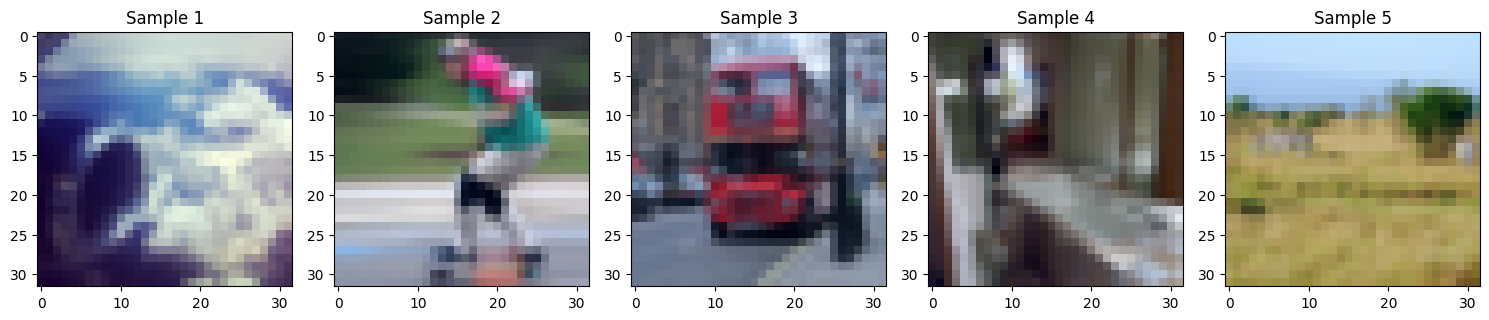

Total Samples: 9841
Image Shape: torch.Size([3, 32, 32])
FMRI Shape: torch.Size([20544])


In [ ]:

# Visualize dataset sample and print basic statistics
import random
import matplotlib.pyplot as plt

# Choose 5 random images from the dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, fmri = myDataset[random.randint(0, len(myDataset) - 1)]
    showImage(axes[i], img, title=f"Sample {i+1}")
plt.tight_layout()
plt.show()

# Print dataset stats
print(f"Total Samples: {len(myDataset)}")
print(f"Image Shape: {img.shape}")
print(f"FMRI Shape: {fmri.shape}")


## 📉 Generator and Discriminator Loss Curves

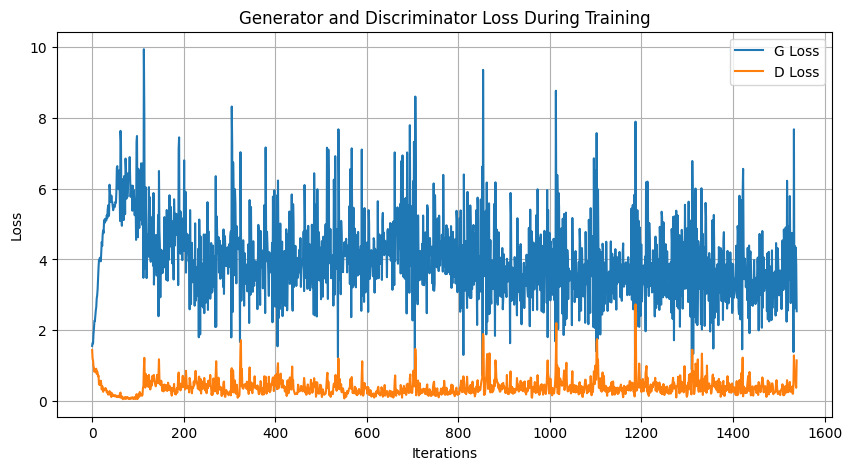

In [ ]:

# Assuming G_losses and D_losses are populated during training
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## 🖼️ Real vs Generated Images Comparison

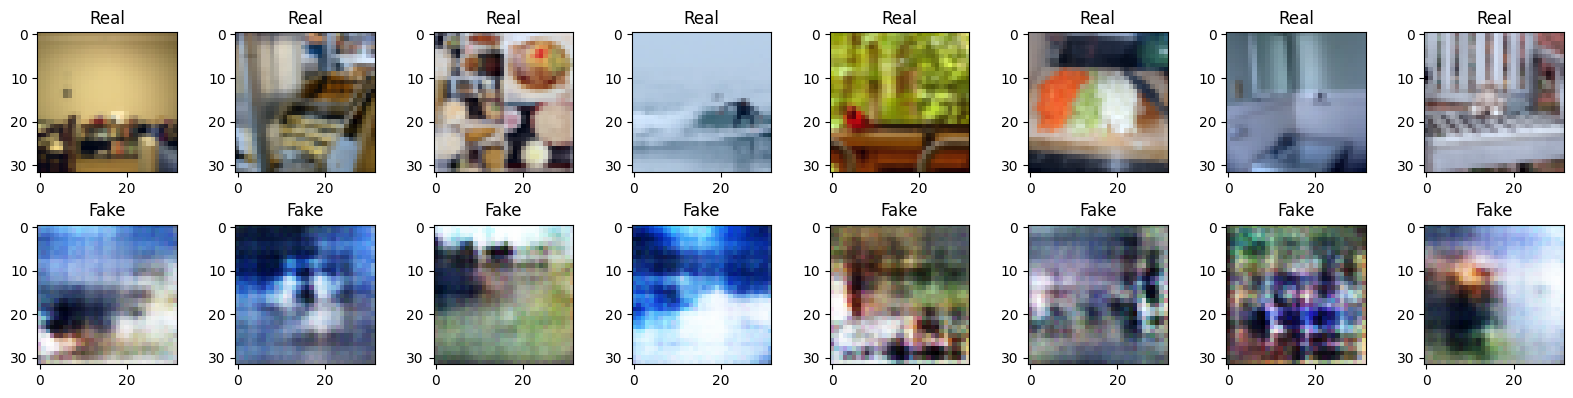

In [ ]:

# Compare real and generated images (assumes fixed_noise and netG are available)
import torchvision.utils as vutils

with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    # Real
    real_img, _ = myDataset[i]
    showImage(axes[0, i], real_img, "Real")
    # Fake
    showImage(axes[1, i], fake_images[i], "Fake")

plt.tight_layout()
plt.show()


## 🧠 t-SNE Visualization of Latent Space

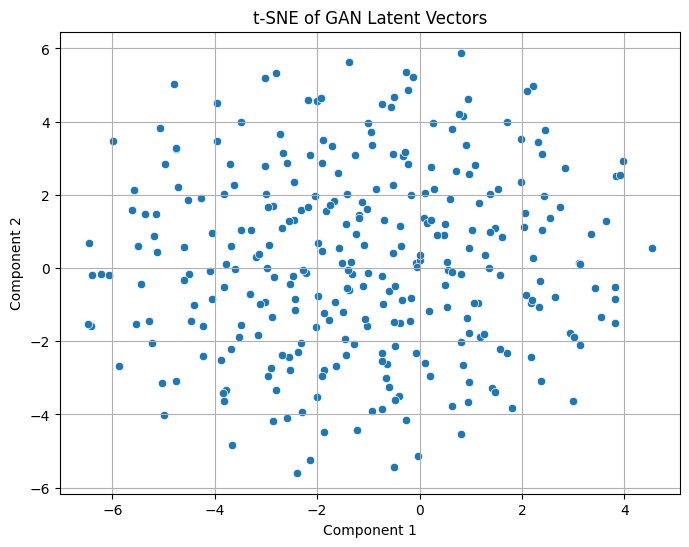

In [ ]:

from sklearn.manifold import TSNE
import seaborn as sns

# Generate latent space and corresponding outputs
latent_vectors = torch.randn(300, nz, 1, 1, device=device)
with torch.no_grad():
    generated_images = netG(latent_vectors).cpu()

# Flatten latent vectors for t-SNE
latent_2d = latent_vectors.view(300, -1).cpu().numpy()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(latent_2d)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1])
plt.title("t-SNE of GAN Latent Vectors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


## 📊 Training Summary Report

In [ ]:

from datetime import timedelta

# Summary data (assuming you tracked the time)
print("📅 Training Complete!")
print(f"🧮 Total Generator Steps: {len(G_losses)}")
print(f"🧮 Total Discriminator Steps: {len(D_losses)}")
print(f"📉 Final Generator Loss: {G_losses[-1]:.4f}")
print(f"📉 Final Discriminator Loss: {D_losses[-1]:.4f}")
print("🧠 Dataset Size:", len(myDataset))


📅 Training Complete!
🧮 Total Generator Steps: 1540
🧮 Total Discriminator Steps: 1540
📉 Final Generator Loss: 2.5361
📉 Final Discriminator Loss: 1.1473
🧠 Dataset Size: 9841


## 🧱 Model Summary with `torchsummary`

In [ ]:

!pip install torchsummary
from torchsummary import summary

print("📌 Generator Summary:")
summary(netG, (nz, 1, 1))

print("\n📌 Discriminator Summary:")
summary(netD, (3, 32, 32))  # Assuming 32x32 RGB images


📌 Generator Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           3,072
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 1,068,928
Trainable params: 1,068,928
Non-trainable params: 0
----------------------------------------------------------------
Input